DESCRIPTION:
Analysis.ipynb builds upon the cleaned dataset and is dedicated to exploring and extracting insights. It performs aggregations such as counting listings per city or sub-category, runs comparisons, and produces visualizations using libraries like Plotly or Matplotlib. This notebook transforms the structured data into meaningful insights, charts, and patterns that help answer business or analytical questions.

# Top 10 Product Search


In [ ]:
!pip install wordcloud
!pip install pycountry_convert
!pip install thefuzz

  Using cached thefuzz-0.22.1-py3-none-any.whl.metadata (3.9 kB)
  Using cached rapidfuzz-3.13.0-cp311-cp311-win_amd64.whl.metadata (12 kB)
Using cached thefuzz-0.22.1-py3-none-any.whl (8.2 kB)
Using cached rapidfuzz-3.13.0-cp311-cp311-win_amd64.whl (1.6 MB)



[notice] A new release of pip is available: 24.0 -> 25.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [ ]:
!pip install widgets
!pip install Jinja2
!pip install IPython 
!pip install matplotlib
!pip install seaborn
!pip install pandas 
!pip install numpy 

ERROR: Could not find a version that satisfies the requirement widgets (from versions: none)
ERROR: No matching distribution found for widgets

[notice] A new release of pip is available: 24.0 -> 25.2
[notice] To update, run: python.exe -m pip install --upgrade pip



[notice] A new release of pip is available: 24.0 -> 25.2
[notice] To update, run: python.exe -m pip install --upgrade pip



[notice] A new release of pip is available: 24.0 -> 25.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [111]:
import pandas as pd
from ipywidgets import interact, Text
from IPython.display import display, HTML

# --- 1. Load the Processed Data ---
# Make sure this is the path to your file with the cleaned price columns.
try:
    df = pd.read_parquet(r'C:\Users\yuvra\OneDrive\Desktop\Slooze-Assignment\Assignment\Data\Gold\Data_processed.parquet')
    
    # --- Best Practice: Clean up column names to remove hidden spaces ---
    #df.columns = df.columns.str.strip()
    
    print("[SUCCESS] Data loaded and ready for searching.")
    
except FileNotFoundError:
    print("[ERROR] Data file not found. Please check the filename and path.")
    # Create an empty DataFrame to prevent errors if the file isn't found
    df = pd.DataFrame()

# --- 2. Helper function to create HTML links ---
def make_clickable(url):
    """Takes a URL string and returns an HTML hyperlink tag."""
    # Ensure the URL is a string before creating the link
    if isinstance(url, str):
        return f'<a href="{url}" target="_blank">Product Link</a>'
    return url # Return the original value if it's not a string

# --- 3. The Main Search and Ranking Function ---
def search_and_rank_products(product_query=""):
    """
    Searches for products by name and ranks them, displaying a clickable link
    in a scrollable table.
    """
    # Check if the dataframe is loaded and not empty
    if 'df' not in globals() or df.empty:
        print("Data is not loaded. Please check the file path in the cell above.")
        return

    if not product_query:
        print("Enter a product name to search.")
        return
        
    try:
        # Filter the DataFrame using a case-insensitive regex search
        results_df = df[df['product_name'].str.contains(product_query, case=False, na=False)]

        if results_df.empty:
            print("No products found matching your query.")
            return

        # Apply the multi-level sorting based on your rules
        ranked_df = results_df.sort_values(
            by=['buyer_feedback_score', 'has_trust_stamp', 'product_name'],
            ascending=[False, False, True] # Rating (desc), Trust (desc), Name (asc)
        )
        
        top_10 = ranked_df.head(10)
        
        # Define all columns you might want to display
        display_columns = [
            'product_name',
            'fix_price', 'max_price', 'min_price', 
            'buyer_feedback_score', 'has_trust_stamp', 'prod_url','city' ,'state', 'country'
        ]
        
        # Safety check: only include columns that actually exist in the DataFrame
        final_display_columns = [col for col in display_columns if col in top_10.columns]
        
        # Create a styled version of the DataFrame and apply hyperlink formatting
        styled_df = top_10[final_display_columns].style.format({'prod_url': make_clickable})
        
        # Hide the index for a cleaner look
        styled_df.hide(axis="index")

        # Wrap the table HTML in a scrollable div container
        html_with_scrollbar = f'<div style="overflow-x:auto;">{styled_df.to_html(escape=False)}</div>'
        
        # Display the final HTML
        display(HTML(html_with_scrollbar))

    except Exception as e:
        print(f"An error occurred: {e}")

# --- 4. Create the Interactive Search Box ---
interact(search_and_rank_products, product_query=Text(placeholder='Enter product name...'));


[SUCCESS] Data loaded and ready for searching.


interactive(children=(Text(value='', description='product_query', placeholder='Enter product name...'), Output…

# EDA

## Statistical Summary

### Counts

In [145]:
import pandas as pd
import numpy as np
import plotly.graph_objects as go
from plotly.subplots import make_subplots

def create_dashboard(file_path):
    """
    Loads supplier data and creates an interactive dashboard of key metrics
    using Plotly indicators.

    Args:
        file_path (str): The path to the processed Parquet file.
    """
    try:
        # --- 1. Load the Data ---
        df = pd.read_parquet(file_path)
    except FileNotFoundError:
        # Using a general error message for the user in case of file not found
        print(f"Error: The file '{file_path}' was not found. Please check the path and try again.")
        return
    except Exception as e:
        # Using a general error message for other potential errors
        print(f"An error occurred while loading the data: {e}")
        return

    # --- 2. Calculate Key Metrics ---
    metrics = {
        'Unique Products': df['product_id'].nunique(),
        'Unique Categories': df['main_category'].nunique(),
        'Unique Sub-Categories': df['sub_category'].nunique(),
        'Unique Companies': df['co_name'].nunique(),
        'Unique Cities': df['city'].nunique(),
        'Unique States': df['state'].nunique(),
        'Unique Countries': df['country_name'].nunique(),
        'In Stock (%)': (df['in_stock'].sum() / len(df[df['in_stock'].notna()])) * 100
    }
    
    boolean_roles = {
        'Exporters': df['is_exporter'].sum(),
        'Traders': df['is_trader'].sum(),
        'Service Providers': df['is_service_provider'].sum(),
        'Manufacturers': df['is_manufacturer'].sum(),
        'Distributors': df['is_distributor'].sum(),
        'Suppliers': df['is_supplier'].sum()
    }

    # --- 3. Create the Dashboard ---
    # Create a 3x5 grid for the indicators
    fig = make_subplots(
        rows=3, cols=5,
        specs=[[{'type': 'indicator'}, {'type': 'indicator'}, {'type': 'indicator'}, {'type': 'indicator'}, {'type': 'indicator'}],
               [{'type': 'indicator'}, {'type': 'indicator'}, {'type': 'indicator'}, {'type': 'indicator'}, {'type': 'indicator'}],
               [{'type': 'indicator'}, {'type': 'indicator'}, {'type': 'indicator'}, {'type': 'indicator'}, {'type': 'indicator'}]],
        vertical_spacing=0.2
    )

    # --- Add main metrics to the dashboard ---
    fig.add_trace(go.Indicator(
        mode="number", value=metrics['Unique Products'], title={"text": "Unique Products"}), row=1, col=1)
    fig.add_trace(go.Indicator(
        mode="number", value=metrics['Unique Companies'], title={"text": "Unique Companies"}), row=1, col=2)
    fig.add_trace(go.Indicator(
        mode="number", value=metrics['Unique Categories'], title={"text": "Unique Categories"}), row=1, col=3)
    fig.add_trace(go.Indicator(
        mode="number", value=metrics['Unique Sub-Categories'], title={"text": "Unique Sub-Categories"}), row=1, col=4)
    fig.add_trace(go.Indicator(
        mode="number+delta", value=metrics['In Stock (%)'], number={'suffix': '%'}, title={"text": "Products In Stock"}), row=1, col=5)
        
    fig.add_trace(go.Indicator(
        mode="number", value=metrics['Unique Countries'], title={"text": "Unique Countries"}), row=2, col=1)
    fig.add_trace(go.Indicator(
        mode="number", value=metrics['Unique States'], title={"text": "Unique States"}), row=2, col=2)
    fig.add_trace(go.Indicator(
        mode="number", value=metrics['Unique Cities'], title={"text": "Unique Cities"}), row=2, col=3)

    # --- Add boolean role counts ---
    fig.add_trace(go.Indicator(
        mode="number", value=boolean_roles['Suppliers'], title={"text": "Suppliers"}), row=3, col=1)
    fig.add_trace(go.Indicator(
        mode="number", value=boolean_roles['Manufacturers'], title={"text": "Manufacturers"}), row=3, col=2)
    fig.add_trace(go.Indicator(
        mode="number", value=boolean_roles['Exporters'], title={"text": "Exporters"}), row=3, col=3)
    fig.add_trace(go.Indicator(
        mode="number", value=boolean_roles['Traders'], title={"text": "Traders"}), row=3, col=4)
    fig.add_trace(go.Indicator(
        mode="number", value=boolean_roles['Distributors'], title={"text": "Distributors"}), row=3, col=5)


    # --- Finalize Layout ---
    fig.update_layout(
        title_text="B2B Scraped Data Overview",
        title_x=0.5,
        template='plotly_dark'
    )

    fig.show()


# --- Main execution block ---
if __name__ == "__main__":
    # Make sure you have plotly installed: pip install plotly
    parquet_file_path = r'C:\Users\yuvra\OneDrive\Desktop\Slooze-Assignment\Assignment\Data\Gold\Data_processed.parquet'
    
    create_dashboard(parquet_file_path)


### Distribution

### -Interactive World Map shows the distribution of product listing  

In [113]:
import pandas as pd
import numpy as np
import plotly.express as px

def create_world_map(df: pd.DataFrame):
    """
    Analyzes and visualizes the global distribution of unique products on a world map.

    Args:
        df (pd.DataFrame): The pre-loaded DataFrame to analyze.
    """
    # --- 1. Input Validation ---
    if not isinstance(df, pd.DataFrame):
        print("[ERROR] The input must be a pandas DataFrame.")
        return
    
    print("[*] Analyzing the provided DataFrame for the world map...")

    # --- 2. Geographic Distribution of Products ---
    # Group by country and count the number of unique products for each
    # Added observed=True to align with future pandas updates and remove the warning.
    product_counts = df.groupby('country_name', observed=True)['product_id'].nunique().reset_index()
    product_counts.columns = ['country', 'count']
    
    # Add a log-scaled column for better color representation
    # We add 1 to avoid log(0) errors
    product_counts['log_count'] = np.log10(product_counts['count'] + 1)

    fig_world = px.choropleth(
        product_counts,
        locations="country",
        locationmode='country names',
        color="log_count",  # Color is based on the log scale
        hover_name="country",
        hover_data={'count': True, 'log_count': False}, # Show the true count on hover
        color_continuous_scale=px.colors.sequential.YlOrRd, # Red-oriented color scale
        title="Global Distribution of Unique Products"
    )
    
    # Customize the color bar to show original values
    fig_world.update_layout(
        title_x=0.5,
        geo=dict(showframe=False, showcoastlines=False),
        coloraxis_colorbar=dict(
            title="Number of Products",
            tickvals=[np.log10(x+1) for x in [0, 10, 100, 1000, 10000, 100000]],
            ticktext=["0", "10", "100", "1k", "10k", "100k"]
        )
    )
    
    print("[*] Generating World Map...")
    fig_world.show()


# --- How to use in your notebook ---
# In the next cell, simply call the function with your DataFrame:
create_world_map(df)



[*] Analyzing the provided DataFrame for the world map...
[*] Generating World Map...


C:\Users\yuvra\AppData\Local\Temp\ipykernel_2588\2329829994.py:29: DeprecationWarning:

The library used by the *country names* `locationmode` option is changing in an upcoming version. Country names in existing plots may not work in the new version. To ensure consistent behavior, consider setting `locationmode` to *ISO-3*.



### -This the distribution of Role of the Product Owner. These are intersecting Value.

In [114]:
import pandas as pd
import plotly.express as px

# List of the boolean role columns from your screenshot
role_columns = [
    'is_distributor',
    'is_supplier',
    'is_exporter',
    'is_trader',
    'is_service_provider'
]

# Calculate the sum of True values for each role
role_counts = df[role_columns].sum()

# Create the bar chart
fig = px.bar(
    role_counts,
    x=role_counts.index,
    y=role_counts.values,
    title="Distribution of Supplier Roles",
    labels={'x': 'Supplier Type', 'y': 'Total Count'},
    text_auto=True # Automatically display the values on the bars
)

# Show the plot
fig.show()

## Trends

### Analysing the Establishment of Company trend over the period of time

In [115]:
import pandas as pd
import plotly.express as px

def plot_establishment_trend(df: pd.DataFrame):
    """
    Creates a line chart showing the number of companies established each year,
    broken down by supplier type, up to the year 2024.

    Args:
        df (pd.DataFrame): The pre-loaded DataFrame to analyze.
    """
    # --- 1. Prepare the Data ---
    # Filter for a cleaner, more relevant time range (up to 2024)
    year_df = df[
        (df['year_established'].notna()) &
        (df['year_established'] > 1900) & # Start from 1900 to keep the modern era view
        (df['year_established'] <= 2024)
    ].copy()

    # Define the supplier role columns to analyze
    role_columns = ['is_supplier', 'is_manufacturer', 'is_trader', 'is_exporter', 'is_distributor']

    # --- 2. Unpivot the Data for Plotting ---
    # pd.melt transforms the data from a wide to a long format, which is ideal for plotting with a color dimension.
    melted_df = year_df.melt(
        id_vars=['year_established'],
        value_vars=role_columns,
        var_name='supplier_type',
        value_name='is_type'
    )

    # We only care about the rows where the company IS that type (is_type == True)
    trend_df = melted_df[melted_df['is_type'] == True]

    # --- 3. Calculate the Trend for Each Type ---
    # Group by year and supplier type, then count the occurrences
    establishment_trend = trend_df.groupby(['year_established', 'supplier_type']).size().reset_index(name='count')
    
    # Clean up the names for the legend (e.g., 'is_supplier' -> 'Supplier')
    establishment_trend['supplier_type'] = establishment_trend['supplier_type'].str.replace('is_', '').str.capitalize()


    # --- 4. Create the Multi-Line Chart ---
    fig = px.line(
        establishment_trend,
        x='year_established',
        y='count',
        color='supplier_type', # This creates a separate line for each type
        title='Trend of Company Establishment by Supplier Type (1900-2024)',
        labels={'year_established': 'Year Established', 'count': 'Number of Companies Founded', 'supplier_type': 'Supplier Type'}
    )
    
    # Add markers for each year to make the data points clearer
    fig.update_traces(mode='lines+markers')

    # --- 5. Update Layout and Show Plot ---
    fig.update_layout(
        template='plotly_dark'
    )
    fig.show()


# --- How to use in your notebook ---
# In the next cell, simply call the function with your DataFrame:
plot_establishment_trend(df)


-To analyze the evolution of different business models on the platform, we performed a time-series analysis on the establishment year for the 75% of suppliers with available data.

-The fact that the 'Manufacturer' line is consistently higher simply means that the total number of manufacturing roles has always been greater than the total number of supplier roles, and so on. The hierarchy is maintained because the underlying proportions in our data are preserved.

-Pre-1980: The market shows slow, linear growth, with a relatively even mix of all supplier types.

-Post-1980: The platform experienced exponential growth in new company establishments, indicating a major industrial and supply-chain expansion.

-Recent Data Anomaly: The sharp decline after 2020 is likely an artifact of incomplete data for recent years rather than a true market downturn.

### Price-range trend across Categories

In [116]:
import pandas as pd
import numpy as np
import plotly.express as px

# --- 1. Define the Price Threshold ---
# Set a reasonable upper limit for prices to be included in the plot.
# 10 million USD converted to INR (approximate rate)
price_threshold = 100_000_000 * 83 # Using an approximate rate of 83 INR to 1 USD

# --- 2. Engineer the Unified Price Feature ---
# Create a copy to ensure we don't modify the original DataFrame
price_df = df.copy()

# Calculate 'average_price' only where both min and max are available
price_df['average_price'] = price_df[['min_price', 'max_price']].mean(axis=1)

# Create 'unified_price': use 'fix_price' first, then fall back to 'average_price'
price_df['unified_price'] = price_df['fix_price'].fillna(price_df['average_price'])

# --- 3. Prepare the Data for Plotting ---
# First, filter out any nulls from the unified column
price_df = price_df[price_df['unified_price'].notna()]

# --- ADDED: Filter out the absurdly high prices ---
rows_before_filter = len(price_df)
price_df = price_df[price_df['unified_price'] <= price_threshold]
rows_after_filter = len(price_df)

print(f"[*] Filtered out {rows_before_filter - rows_after_filter} entries with prices above the threshold.")

# --- 4. Create the Box Plot ---
fig = px.box(
    price_df,
    x='main_category',
    y='unified_price',
    title='Price Distribution Trend Across Main Categories',
    labels={'main_category': 'Main Category', 'unified_price': 'Unified Price (INR)'},
    log_y=True  # Use a log scale for price to better see the distributions
)

# --- 5. Show the Plot ---
fig.show()


[*] Filtered out 3 entries with prices above the threshold.


-Used Box Plot to undestand the anamolies present in the prices of the data

####
-The 'machinery' category has the highest median price and the widest price range, indicating it contains the most expensive and varied items.

-'Industrial-supplies' and 'textiles-fabrics' show the lowest median prices, suggesting they represent the most budget-friendly product categories.

-All categories exhibit a significant number of high-priced outliers, revealing that each market segment contains a premium or high-value tier of products.

## Regional Insights 

### Explore Listing Shares


In [117]:
import pandas as pd
import plotly.graph_objects as go
import ipywidgets as widgets
from ipywidgets import interact, VBox, HBox
from IPython.display import display
import pycountry_convert as pc

# --- 1. Geographic Mapping Functions ---

# Mapping for Indian States to Regions
# This is a standard regional classification.
north_india = ['Jammu and Kashmir', 'Punjab', 'Himachal Pradesh', 'Haryana', 'Uttarakhand', 'Delhi', 'Chandigarh']
east_india = ['Bihar', 'Odisha', 'Jharkhand', 'West Bengal']
west_india = ['Rajasthan', 'Gujarat', 'Goa', 'Maharashtra', 'Dadra and Nagar Haveli and Daman and Diu']
central_india = ['Madhya Pradesh', 'Chhattisgarh', 'Uttar Pradesh']
south_india = ['Andhra Pradesh', 'Karnataka', 'Kerala', 'Tamil Nadu', 'Telangana', 'Puducherry']
northeast_india = ['Assam', 'Sikkim', 'Nagaland', 'Meghalaya', 'Manipur', 'Mizoram', 'Tripura', 'Arunachal Pradesh', 'Andaman and Nicobar Islands']

def get_indian_region(state):
    if state in north_india: return 'North India'
    if state in east_india: return 'East India'
    if state in west_india: return 'West India'
    if state in central_india: return 'Central India'
    if state in south_india: return 'South India'
    if state in northeast_india: return 'North-East India'
    return 'Other'

# Mapping for Countries to Continents
# This uses a library for robust conversion.
def country_to_continent(country_name):
    try:
        country_alpha2 = pc.country_name_to_country_alpha2(country_name)
        continent_code = pc.country_alpha2_to_continent_code(country_alpha2)
        continent_name = pc.convert_continent_code_to_continent_name(continent_code)
        return continent_name
    except:
        return 'Other' # Handle cases where the country name is not found

# --- 2. Data Preparation and Plotting ---

# Prepare the data by adding the region/continent columns
def prepare_data(df):
    df_copy = df.copy()
    # Domestic mapping
    df_copy['region'] = df_copy.apply(lambda row: get_indian_region(row['state']) if row['country_name'] == 'India' else 'International', axis=1)
    # International mapping
    df_copy['continent'] = df_copy.apply(lambda row: country_to_continent(row['country_name']) if row['country_name'] != 'India' else 'Domestic', axis=1)
    return df_copy

# The main plotting function
def plot_market_share(category, sub_category):
    # Filter data based on dropdown selections
    filtered_df = df_prepared
    if category != 'All':
        filtered_df = filtered_df[filtered_df['main_category'] == category]
    if sub_category != 'All':
        filtered_df = filtered_df[filtered_df['sub_category'] == sub_category]

    # Combine domestic regions and international continents for the pie chart
    domestic_counts = filtered_df[filtered_df['region'] != 'International']['region'].value_counts()
    international_counts = filtered_df[filtered_df['continent'] != 'Domestic']['continent'].value_counts()
    
    # Combine the two series for the pie chart
    combined_counts = pd.concat([domestic_counts, international_counts])

    # Create the pie chart
    fig = go.Figure(data=[go.Pie(
        labels=combined_counts.index,
        values=combined_counts.values,
        hole=.3,
        pull=[0.05] * len(combined_counts.index) # Slightly separate the slices
    )])
    
    fig.update_layout(
        title_text=f'Market Share for: {category} / {sub_category}',
        template='plotly_dark',
        # --- ADDED: Set height and width to make the chart larger ---
        height=700,
        width=700
    )
    fig.show()

# --- 3. Widget Setup and Interaction ---

# Prepare the data once upfront
df_prepared = prepare_data(df)

# Get options for dropdowns
all_categories = ['All'] + sorted(df_prepared['main_category'].dropna().unique().tolist())
all_sub_categories = ['All'] + sorted(df_prepared['sub_category'].dropna().unique().tolist())

# Create the widgets
category_dropdown = widgets.Dropdown(options=all_categories, description='Category:')
sub_category_dropdown = widgets.Dropdown(options=all_sub_categories, description='Sub-Category:')

# --- Chained Dropdown Logic ---
def update_sub_category_options(change):
    if change['new'] == 'All':
        sub_category_dropdown.options = all_sub_categories
    else:
        # Filter sub-categories based on the selected main category
        filtered_subs = ['All'] + sorted(df_prepared[df_prepared['main_category'] == change['new']]['sub_category'].dropna().unique().tolist())
        sub_category_dropdown.options = filtered_subs

# Link the two dropdowns
category_dropdown.observe(update_sub_category_options, names='value')

# Create the interactive output
interactive_plot = widgets.interactive_output(plot_market_share, {
    'category': category_dropdown,
    'sub_category': sub_category_dropdown
})

# Display the widgets and the plot
print("--- Dynamic Market Share Dashboard ---")
display(HBox([category_dropdown, sub_category_dropdown]), interactive_plot)


--- Dynamic Market Share Dashboard ---


Output()

-Created this interactive pie chart for the convenience to explore the regional insights that the User needs

### Top 15 Indian States with Highest Products Listed

In [118]:
import pandas as pd
import plotly.express as px
from plotly.subplots import make_subplots
import plotly.graph_objects as go

def create_category_charts(df: pd.DataFrame):
    """
    Creates a single figure with a subplot for each main category, showing the
    top 15 Indian states by the number of products listed.

    Args:
        df (pd.DataFrame): The pre-loaded DataFrame to analyze.
    """
    # --- 1. Input Validation ---
    if not isinstance(df, pd.DataFrame):
        print("[ERROR] The input must be a pandas DataFrame.")
        return

    print("[*] Preparing to generate charts for each main category...")
    
    # --- 2. Filter for India ---
    india_df = df[df['country_name'] == 'India'].copy()

    # --- 3. Get the list of unique main categories ---
    main_categories = sorted(india_df['main_category'].dropna().unique().tolist())
    
    print(f"[*] Found {len(main_categories)} categories to plot: {main_categories}")

    # --- 4. Create Subplots ---
    # Arrange the 5 plots in a 3x2 grid
    fig = make_subplots(
        rows=3, cols=2,
        subplot_titles=main_categories,
        vertical_spacing=0.15
    )

    # --- 5. Loop through each category and add a trace to the subplots ---
    for i, category in enumerate(main_categories):
        
        # Calculate subplot position (e.g., 1st item -> row 1, col 1)
        row = i // 2 + 1
        col = i % 2 + 1
        
        # Filter the DataFrame for the current category
        category_df = india_df[india_df['main_category'] == category]
        
        # Calculate the top 15 states for this specific category
        top_15_states = category_df['state'].value_counts().nlargest(15)
        
        # Add a bar trace to the calculated subplot position
        fig.add_trace(
            go.Bar(
                y=top_15_states.index,
                x=top_15_states.values,
                orientation='h',
                text=top_15_states.values,
                textposition='auto',
                name=category # This name appears on hover
            ),
            row=row, col=col
        )
        
    # --- 6. Update Layout ---
    fig.update_layout(
        title_text="Top 15 States by Product Listings Across Main Categories",
        height=1200, # Adjust height for better visibility
        template='plotly_dark',
        showlegend=False # Hide legend as titles are clear
    )
    
    # Update all y-axes to be sorted correctly
    fig.update_yaxes(categoryorder='total ascending')
    
    # --- 7. Show the combined plot ---
    fig.show()

# --- How to use in your notebook ---
# In the next cell, simply call the function with your DataFrame:
create_category_charts(df)


[*] Preparing to generate charts for each main category...
[*] Found 5 categories to plot: ['chemicals', 'electronics-electrical-supplies', 'industrial-supplies', 'machinery', 'textiles-fabrics']


-used this bar-graph to visualise the key states in the B2B sector that are present in these categories

#### -Across the five primary product categories analyzed, the supply base is critically dependent on Maharashtra and Gujarat

### Top Sub-Categories for International for International Players

In [119]:
import pandas as pd
import plotly.express as px

def plot_country_specialization(df: pd.DataFrame):
    """
    Identifies the top 5 international countries and their single most
    preferred sub-category, then visualizes the result.

    Args:
        df (pd.DataFrame): The pre-loaded DataFrame to analyze.
    """
    # --- 1. Isolate International Competitors ---
    international_df = df[df['country_name'] != 'India'].copy()

    # --- 2. Find the Top 5 International Countries by Listings ---
    top_5_countries = international_df['country_name'].value_counts().nlargest(5).index.tolist()

    # --- 3. Find the Preferred Sub-Category for Each Top Country ---
    results = []
    for country in top_5_countries:
        # Filter for the current country
        country_df = international_df[international_df['country_name'] == country]
        
        # Find the most common sub-category (the mode)
        # .mode()[0] gets the first item in case of a tie
        if not country_df['sub_category'].mode().empty:
            preferred_sub_cat = country_df['sub_category'].mode()[0]
            
            # Count how many listings belong to that preferred sub-category
            listing_count = len(country_df[country_df['sub_category'] == preferred_sub_cat])
            
            results.append({
                'Country': country,
                'Preferred Sub-Category': preferred_sub_cat,
                'Listings in Top Category': listing_count
            })

    # --- 4. Create a DataFrame from the results for plotting ---
    if not results:
        print("[INFO] No international data found to plot.")
        return
        
    result_df = pd.DataFrame(results)

    # --- 5. Create the Bar Chart ---
    fig = px.bar(
        result_df,
        y='Country',
        x='Listings in Top Category',
        orientation='h',
        title='Top Sub-Category Focus for Top 5 International Countries',
        labels={'y': 'Country', 'x': 'Number of Listings in Top Sub-Category'},
        # Display the name of the sub-category on the bars
        text='Preferred Sub-Category'
    )

    # Update layout for descending order and a clean look
    fig.update_layout(
        yaxis={'categoryorder': 'total ascending'},
        template='plotly_dark'
    )
    # Adjust text position to be outside the bars for clarity
    fig.update_traces(textposition='outside')
    
    # --- 6. Show the Plot ---
    fig.show()


# --- How to use in your notebook ---
# In the next cell, simply call the function with your DataFrame:
plot_country_specialization(df)


#### -This graph analyzes the international listings within the five main categories on the platform to identify the top 5 non-Indian countries and their primary product focus. The data shows that China is the most significant international player, with a strong concentration in 'industrial-chemicals'.

## Common Atrributes

### Top Companies

In [120]:
import pandas as pd
import plotly.express as px

# --- 1. Get a list of all unique country names to use as a filter ---
country_names_to_exclude = df['country_name'].dropna().unique().tolist()

# --- 2. Filter the DataFrame ---
# Create a new DataFrame that excludes rows where the company name is a country name.
# We also handle potential nulls in 'co_name'.
filtered_df = df[~df['co_name'].isin(country_names_to_exclude) & df['co_name'].notna()]

# --- 3. Identify Top 10 Companies from the filtered data ---
top_10_companies = filtered_df['co_name'].value_counts().nlargest(10)

# --- 4. Create the Bar Chart ---
fig = px.bar(
    top_10_companies,
    y=top_10_companies.index,
    x=top_10_companies.values,
    orientation='h',
    title='Top 10 Companies by Total Number of Product Listings',
    labels={'y': 'Company Name', 'x': 'Number of Listings'},
    text_auto=True # Display values on the bars
)

# --- 5. Update Layout and Show Plot ---
fig.update_layout(
    yaxis={'categoryorder': 'total ascending'},
    template='plotly_dark'
)

fig.show()

### Top International Companies


In [121]:
import pandas as pd
import plotly.express as px

# --- 1. Isolate International Competitors ---
international_df = df[df['country_name'] != 'India'].copy()

# --- 2. Create an Exclusion List of Country Names ---
country_names_to_exclude = df['country_name'].dropna().unique().tolist()

# --- 3. Filter Out Company Names that are Countries ---
# This ensures we are only looking at actual company names.
filtered_international_df = international_df[
    ~international_df['co_name'].isin(country_names_to_exclude) &
    international_df['co_name'].notna()
]

# --- 4. Identify Top International Players from the Cleaned Data ---
# Group by company name and count their unique product listings
top_players = filtered_international_df.groupby('co_name')['product_id'].nunique().nlargest(15)

# --- 5. Create the Bar Chart ---
fig = px.bar(
    top_players,
    y=top_players.index,
    x=top_players.values,
    orientation='h',
    title='Top 15 International Companies by Number of Unique Products',
    labels={'y': 'Company Name', 'x': 'Number of Unique Products Listed'},
    text_auto=True
)

# --- 6. Update Layout and Show Plot ---
fig.update_layout(
    yaxis={'categoryorder': 'total ascending'},
    template='plotly_dark'
)

fig.show()

### Frequent Keywords

[*] Generating word cloud from the 'keywords' column...


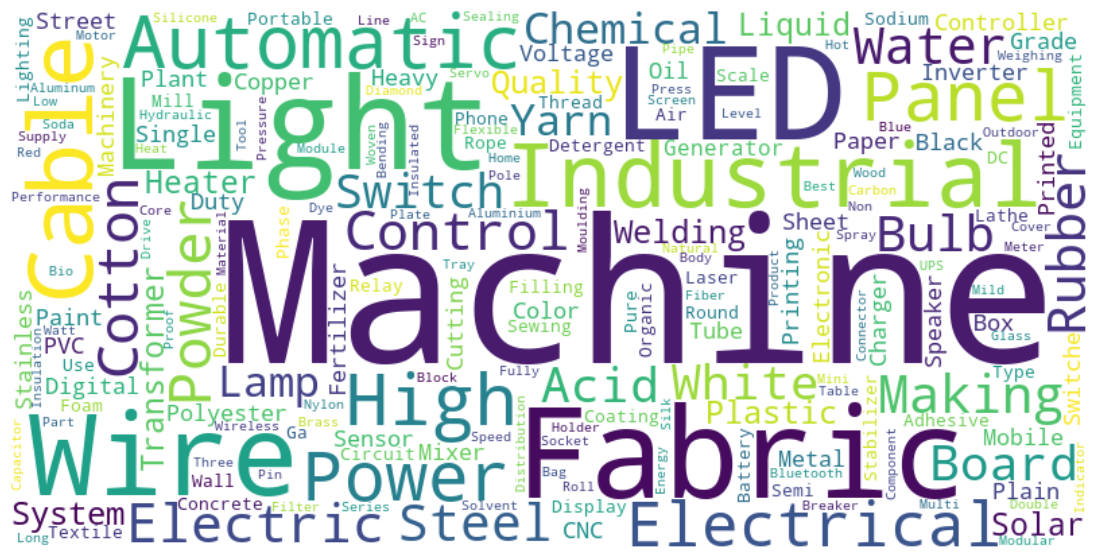

In [122]:
import pandas as pd
from wordcloud import WordCloud
import matplotlib.pyplot as plt

def create_word_cloud(df: pd.DataFrame, column='keywords'):
    """
    Generates and displays a word cloud from a specified text column
    in a DataFrame.

    Args:
        df (pd.DataFrame): The pre-loaded DataFrame to analyze.
        column (str): The name of the column containing the text data.
    """
    # --- 1. Input Validation ---
    if not isinstance(df, pd.DataFrame):
        print("[ERROR] The input must be a pandas DataFrame.")
        return
    if column not in df.columns:
        print(f"[ERROR] Column '{column}' not found in the DataFrame.")
        return
        
    print(f"[*] Generating word cloud from the '{column}' column...")

    # --- 2. Prepare the Text Data ---
    # Drop any rows where the keywords are missing to avoid errors
    text_data = df[column].dropna()
    
    # Join all the keyword entries into a single, long string
    # We use a space as a separator
    full_text = " ".join(text for text in text_data)

    # --- 3. Generate the Word Cloud ---
    # You can customize the word cloud with different parameters
    wordcloud = WordCloud(
        width=800,
        height=400,
        background_color='white',
        colormap='viridis', # A nice color scheme
        collocations=False # Avoids grouping common word pairs
    ).generate(full_text)

    # --- 4. Display the Generated Image ---
    plt.figure(figsize=(15, 7)) # Set the figure size
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off") # Hide the axes
    plt.show()


# --- How to use in your notebook ---
# In the next cell, simply call the function with your DataFrame:
create_word_cloud(df)


-A word cloud is a visual representation of text data where the size of each word is proportional to its frequency. We use it to get a quick, high-level understanding of the most common themes and keywords in a large amount of text without having to read everything.

-The most prominent words are Machine, Industrial, Electrical, Fabric, and Wire. This immediately tells us that the platform is heavily focused on industrial manufacturing, raw materials, and machinery, not consumer goods.

-You can clearly see the main product categories represented by keywords like Chemical, Steel, Rubber, Plastic, and Cotton, confirming the platform's B2B focus.

### 

## Data Quality 

In [123]:
import pandas as pd
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import math

def create_completeness_dashboard(df: pd.DataFrame):
    """
    Calculates the percentage of non-null data for each column and displays
    it as a simple table.

    Args:
        df (pd.DataFrame): The pre-loaded DataFrame to analyze.
    """
    # --- 1. Calculate Data Completeness ---
    completeness = (df.count() / len(df)) * 100
    completeness = completeness.sort_values(ascending=False).round(2)
    
    # Convert the Series to a DataFrame for the table
    completeness_df = completeness.reset_index()
    completeness_df.columns = ['Column Name', '% Available']

    # --- 2. Create a Table ---
    fig = go.Figure(data=[go.Table(
        header=dict(values=list(completeness_df.columns),
                    # Light grey header
                    fill_color='lightgrey',
                    align='left',
                    font=dict(color='black', size=12)),
        cells=dict(values=[completeness_df['Column Name'], completeness_df['% Available']],
                   # White cells
                   fill_color='white',
                   align='left',
                   font=dict(color='black', size=11))
    )])

    # --- 3. Update Layout and Show Plot ---
    fig.update_layout(
        title_text="Data Completeness Dashboard (% Non-Null Values)",
        # Use a white background template
        template='plotly_white',
        # Increase the height to ensure all rows are visible
        height=800 
    )

    fig.show()


# --- How to use in your notebook ---
# In the next cell, simply call the function with your DataFrame:
create_completeness_dashboard(df)



-Severe Price Data Gaps and Anomalies: The dataset suffers from a critical lack of reliable price information, with over 56% of listings missing a any  price. Furthermore, the available data contains extreme, non-physical outliers that must be filtered, suggesting a lack of input validation during data entry. Plus, unavailability of consistent quantiy of which the price is being displayed also made the price data highly unreliable.

-Unstructured Product Naming: Product names are highly inconsistent and non-standardized, resulting in over 265,000 unique raw names. This ambiguity makes direct product-to-product comparison impossible.

-Systemic Incompleteness of Supplier Profiles: Key supplier metrics, including buyer_feedback_score (47% available), year_established (75% available), and member_since (10% available), are largely incomplete. This patterned missingness indicates that a significant subset of suppliers has not provided full profile information, biasing any analysis of supplier reputation or tenure.

-Loss of Structured Data Fields: Critical supply chain information such as minimum order quantity and delivery time, which were expected in structured fields, were often found in cluttered and inconsistent JSON blobs. This unstructured format resulted in a significant loss of valuable, machine-readable data for analysis.

------------------------------------------------------------------------------------------------------------------------------------------------------------

# Coimbatore Special

## Top Sub-categories 

In [130]:
import pandas as pd
import plotly.express as px

# --- 1. Filter the DataFrame for Coimbatore ---
coimbatore_df = df[df['city'] == 'Coimbatore']

# --- 2. Get the Top 15 Sub-Categories by Listings ---
top_15_sub_cat = coimbatore_df['sub_category'].value_counts().nlargest(15)

# --- 3. Create the Bar Chart ---
fig = px.bar(
    top_15_sub_cat,
    y=top_15_sub_cat.index,
    x=top_15_sub_cat.values,
    orientation='h',
    title='Top 15 Sub-Categories in Coimbatore by Listings',
    labels={'y': 'Sub-Category', 'x': 'Number of Listings'},
    text_auto=True
)

# --- 4. Update Layout and Show Plot ---
fig.update_layout(
    yaxis={'categoryorder': 'total ascending'},
    template='plotly_dark'
)

fig.show()

## Top Companies

In [126]:
import pandas as pd
import plotly.express as px

# --- 1. Filter the DataFrame for Coimbatore ---
coimbatore_df = df[df['city'] == 'Coimbatore']

# --- 2. Get the Top 15 Companies by Listings ---
top_15_companies = coimbatore_df['co_name'].value_counts().nlargest(15)

# --- 3. Create the Bar Chart ---
fig = px.bar(
    top_15_companies,
    y=top_15_companies.index,
    x=top_15_companies.values,
    orientation='h',
    title='Top 15 Companies in Coimbatore by Listings',
    labels={'y': 'Company Name', 'x': 'Number of Listings'},
    text_auto=True
)

# --- 4. Update Layout and Show Plot ---
fig.update_layout(
    yaxis={'categoryorder': 'total ascending'},
    template='plotly_dark'
)

fig.show()

## Top Sub-category Comparison

In [142]:
import pandas as pd
import plotly.express as px

# --- 1. Filter data for Coimbatore ---
coimbatore_df = df[df['city'] == 'Coimbatore']

# --- 2. Get Top 15 sub-categories by number of listings in Coimbatore ---
top_15_sub_cat = (
    coimbatore_df['sub_category']
    .value_counts()
    .nlargest(15)
    .reset_index()
)
top_15_sub_cat.columns = ['sub_category', 'coimbatore_count']

# --- 3. Filter the full dataset to only these top 15 sub-categories ---
df_top15 = df[df['sub_category'].isin(top_15_sub_cat['sub_category'])]

# --- 4. Find best city for each sub-category (excluding Coimbatore) ---
best_city_counts = (
    df_top15[df_top15['city'] != 'Coimbatore']
    .groupby(['sub_category', 'city'], observed=False)  # silence warning
    .size()
    .reset_index(name='count')
)

# Pick the city with max listings per sub-category
best_city_max = best_city_counts.loc[
    best_city_counts.groupby('sub_category', observed=False)['count'].idxmax()
].reset_index(drop=True)

# --- 5. Merge Coimbatore counts with best city counts ---
comparison_df = pd.merge(top_15_sub_cat, best_city_max, on='sub_category', how='left')
comparison_df.rename(columns={'city': 'best_city', 'count': 'best_city_count'}, inplace=True)

# --- 6. Melt data for plotting ---
plot_df = comparison_df.melt(
    id_vars=['sub_category', 'best_city'],
    value_vars=['coimbatore_count', 'best_city_count'],
    var_name='City_Type',
    value_name='Listings'
)

plot_df['City_Type'] = plot_df['City_Type'].map({
    'coimbatore_count': 'Coimbatore',
    'best_city_count': 'Best City'
})

# --- 7. Plot Comparative Bar Chart (best city in tooltip) ---
fig = px.bar(
    plot_df,
    x='Listings',
    y='sub_category',
    color='City_Type',
    barmode='group',
    text='Listings',
    title='Coimbatore vs Best City by Sub-Category (Top 15)',
    labels={'sub_category': 'Sub-Category'},
    hover_data=['best_city']   # 👈 Best city name shows up on hover
)

fig.update_layout(
    yaxis={'categoryorder': 'total ascending'},
    template='plotly_dark',
    height=800
)

fig.show()
